This notebook builds on the cleaned warehouse and mart created in the project to explore **product-level engagement patterns**.

**Goals:**

- Identify which products have the highest average engagement
- Understand how stable or volatile engagement is for each product over time
- Quantify data quality issues that affect product-level analysis (e.g., missing `lp_id`)


In [1]:
import duckdb
import pandas as pd
import matplotlib.pyplot as plt

plt.rcParams["figure.figsize"] = (10, 5)

# Connect to the DuckDB warehouse
# If you launched Jupyter from the project root, use this:
# con = duckdb.connect("warehouse/edtech_engagement.duckdb")
#
# If your notebook is inside the notebooks/ folder, use this:
con = duckdb.connect("../warehouse/edtech_engagement.duckdb")

con

## 1. Inspect Available Tables

In [2]:
con.execute("""
SELECT table_schema, table_name
FROM information_schema.tables
WHERE table_schema = 'analytics'
ORDER BY table_name;
""").df()

,table_schema,table_name
0,analytics,fct_daily_engagement
1,analytics,my_first_dbt_model
2,analytics,my_second_dbt_model
3,analytics,stg_districts
4,analytics,stg_engagement
5,analytics,stg_products


## 2. Preview `fct_daily_engagement`

In [3]:
fct_sample = con.execute("""
SELECT *
FROM analytics.fct_daily_engagement
LIMIT 10;
""").df()

fct_sample

,lp_id,usage_date,avg_pct_access,avg_engagement_index
0,52758,2020-01-06,0.144701,3.914070
1,64915,2020-01-08,0.845741,190.191049
2,63335,2020-01-09,0.145243,14.051758
3,85975,2020-01-09,1.061325,143.647988
4,32340,2020-01-10,0.177241,13.064338
5,95253,2020-01-11,0.201837,37.798095
6,28504,2020-01-12,0.363723,37.988000
7,13591,2020-01-13,0.154049,10.322583
8,39463,2020-01-13,0.001600,0.695000
9,69429,2020-01-13,0.253099,12.316049


## 3. Product Coverage in the Fact Table

In [4]:
coverage = con.execute("""
SELECT
    COUNT(*) AS total_rows,
    COUNT(DISTINCT lp_id) AS distinct_products,
    SUM(CASE WHEN lp_id IS NULL THEN 1 ELSE 0 END) AS null_lp_rows
FROM analytics.fct_daily_engagement;
""").df()

coverage["pct_null_lp"] = coverage["null_lp_rows"] / coverage["total_rows"]
coverage

,total_rows,distinct_products,null_lp_rows,pct_null_lp
0,1110972,8646,158.0,0.000142


## 4. Top Products by Average Engagement Index

In [5]:
top_products = con.execute("""
SELECT
    lp_id,
    AVG(avg_engagement_index) AS avg_engagement,
    COUNT(*) AS days_observed
FROM analytics.fct_daily_engagement
WHERE lp_id IS NOT NULL
GROUP BY lp_id
HAVING days_observed >= 10   -- filter out products with very few days
ORDER BY avg_engagement DESC
LIMIT 20;
""").df()

top_products

,lp_id,avg_engagement,days_observed
0,95731,10042.970149,366
1,32213,5110.669611,366
2,26488,4061.778756,366
3,25010,3773.760738,325
4,61292,3296.521110,199
5,47364,2633.153194,366
6,30717,2377.430845,275
7,20069,1909.353161,366
8,98845,1652.930951,292
9,24711,1273.341913,366


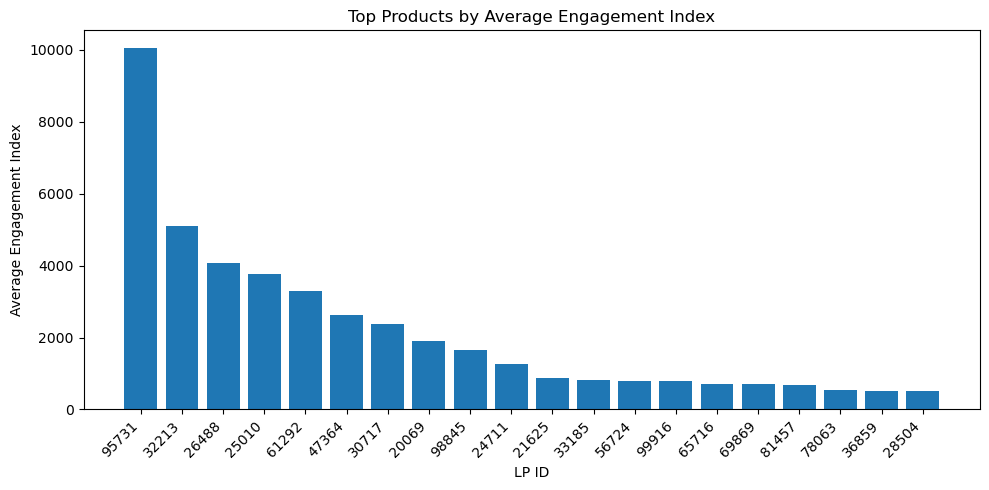

In [6]:
plt.bar(top_products["lp_id"].astype(str), top_products["avg_engagement"])
plt.title("Top Products by Average Engagement Index")
plt.xlabel("LP ID")
plt.ylabel("Average Engagement Index")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

## 5. Engagement Volatility by Product

In [7]:
volatility = con.execute("""
SELECT
    lp_id,
    AVG(avg_engagement_index) AS avg_engagement,
    STDDEV_POP(avg_engagement_index) AS engagement_volatility,
    COUNT(*) AS days_observed
FROM analytics.fct_daily_engagement
WHERE lp_id IS NOT NULL
GROUP BY lp_id
HAVING days_observed >= 30
ORDER BY engagement_volatility DESC
LIMIT 20;
""").df()

volatility

,lp_id,avg_engagement,engagement_volatility,days_observed
0,95731,10042.970149,9262.152205,366
1,32213,5110.669611,4678.166308,366
2,25010,3773.760738,4313.840017,325
3,30717,2377.430845,3670.707815,275
4,26488,4061.778756,3473.361230,366
5,47364,2633.153194,2432.497842,366
6,20069,1909.353161,2054.372581,366
7,98845,1652.930951,2012.379712,292
8,61292,3296.521110,1846.499199,199
9,24711,1273.341913,1691.908592,366


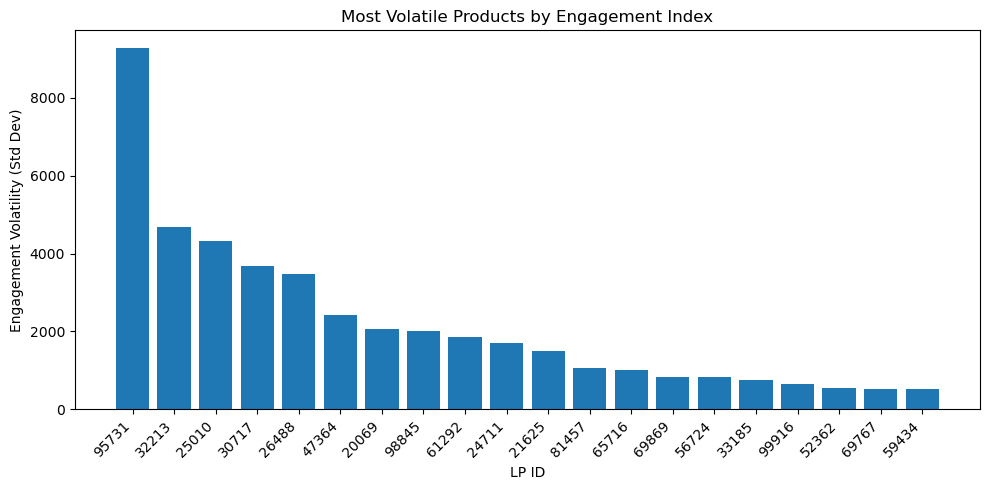

In [8]:
plt.bar(volatility["lp_id"].astype(str), volatility["engagement_volatility"])
plt.title("Most Volatile Products by Engagement Index")
plt.xlabel("LP ID")
plt.ylabel("Engagement Volatility (Std Dev)")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

## 6. Join to Product Metadata

In [9]:
print(
    "Product metadata join is not yet wired. "
    "Current analysis is at the lp_id level only. "
    "Future work: expose lp_id in stg_products via dbt and join on that key."
)

Product metadata join is not yet wired. Current analysis is at the lp_id level only. Future work: expose lp_id in stg_products via dbt and join on that key.


## 7. Summary & Next Steps

**What we learned in this notebook:**

- Which products have the highest *average* engagement (with a minimum activity threshold)
- Which products exhibit the most *volatile* engagement behavior over time
- How much missing `lp_id` data exists and how that impacts product-level analysis

**Possible next steps:**

- Group products by category or provider to compare vendor-level engagement
- Segment districts by which products they rely on most
- Feed product-level features into a district clustering or forecasting model